In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import pathlib
import torchvision
from torch.optim.lr_scheduler import ExponentialLR
import torchvision.utils as vutils

import os
import numpy as np
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
from matplotlib.ticker import MaxNLocator

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
pd.options.display.float_format = '{:.6f}'.format
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

import datetime
import time
import random
import os

# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda:0

NVIDIA GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
path = "C:/Users/rezan/Arupreza/Universal Wavelet/Wavelet_Feature/"

In [3]:
Kia_Normal_Wavelet = pd.read_csv(path+"Kia_Normal_Wavelet.csv")
Kia_Fuzz_Wavelet = pd.read_csv(path+"Kia_Fuzz_Wavelet.csv")
Kia_DoS_Wavelet = pd.read_csv(path+"Kia_DoS_Wavelet.csv")
Kia_Replay_Wavelet = pd.read_csv(path+"Kia_Replay_Wavelet.csv")
Kia_Mal_Wavelet = pd.read_csv(path+"Kia_Malfunction_Wavelet.csv")
kia = pd.concat([Kia_Normal_Wavelet, Kia_Fuzz_Wavelet, Kia_DoS_Wavelet, Kia_Replay_Wavelet, Kia_Mal_Wavelet], axis=0)
print("Kia Length: ", kia.shape)

Sonata_Normal_Wavelet = pd.read_csv(path+"Sonata_Normal_Wavelet.csv")
Sonata_Fuzz_Wavelet = pd.read_csv(path+"Sonata_Fuzz_Wavelet.csv")
Sonata_DoS_Wavelet = pd.read_csv(path+"Sonata_DoS_Wavelet.csv")
Sonata_Replay_Wavelet = pd.read_csv(path+"Sonata_Replay_Wavelet.csv")
Sonata_Mal_Wavelet = pd.read_csv(path+"Sonata_Malfunction_Wavelet.csv")
sonata = pd.concat([Sonata_Normal_Wavelet, Sonata_Fuzz_Wavelet, Sonata_DoS_Wavelet, Sonata_Replay_Wavelet, Sonata_Mal_Wavelet], axis=0)
sonata= sonata[40:]
print("Sonata Length: ", sonata.shape)

Kia Length:  (8100, 116)
Sonata Length:  (6800, 116)


In [4]:
def permute(df):
    RearrangeData = np.array(df).reshape(-1,100,df.shape[1])
    shuffle_idx = np.random.permutation(RearrangeData.shape[0])
    RearrangeData = RearrangeData[shuffle_idx]
    print('Old:', RearrangeData.shape)
    RearrangeData = RearrangeData.reshape(df.shape[0], df.shape[1])
    print('Updated:',RearrangeData.shape)
    return RearrangeData

In [5]:
kia = permute(kia)
sonata = permute(sonata)

Old: (81, 100, 116)
Updated: (8100, 116)
Old: (68, 100, 116)
Updated: (6800, 116)


In [6]:
kia_train, Kia_val = train_test_split(kia, test_size=0.10, random_state=5, shuffle=False)
sonata_train, sonata_val = train_test_split(sonata, test_size=0.10, random_state=5, shuffle=False)

In [7]:
val = pd.concat([pd.DataFrame(Kia_val), pd.DataFrame(sonata_val)], axis=0)

In [8]:
"""val.to_csv(path+'val.csv', index = False)
pd.DataFrame(kia_train).to_csv(path+'kia.csv', index = False)
pd.DataFrame(sonata_train).to_csv(path+'sonata.csv', index = False)"""

"val.to_csv(path+'val.csv', index = False)\npd.DataFrame(kia_train).to_csv(path+'kia.csv', index = False)\npd.DataFrame(sonata_train).to_csv(path+'sonata.csv', index = False)"

In [9]:
kia = np.array(pd.read_csv(path+"kia.csv"))
sonata = np.array(pd.read_csv(path+"sonata.csv"))
val = np.array(pd.read_csv(path+"val.csv"))

In [10]:
def create_train_data(X, y):
    X_train = []
    y_train = []
    df = []
    timestamp = 10
    length = len(X)

    for i in range(timestamp, length, timestamp):
        x1 = X[i-timestamp:i]
        y1 = y[i]
        X_train.append(x1)
        y_train.append(y1)
        features = np.reshape(x1, (1, 10, 114))
        df.append((features, y1))

        if i >= length:
            break

    return X_train, y_train, df

In [11]:
concat_Kia_X = kia[:,:114]
#concat_Kia_X = scaler.fit_transform(concat_Kia_X)
concat_Kia_y = kia[:,115]
concat_Sonata_X = sonata[:,:114]
#concat_Sonata_X = scaler.fit_transform(concat_Sonata_X)
concat_Sonata_y = sonata[:,115]
val_X = val[:,:114]
#concat_Sonata_X = scaler.fit_transform(concat_Sonata_X)
val_y = val[:,115]

In [12]:
x_Kia, y_Kia, z_Kia = create_train_data(concat_Kia_X, concat_Kia_y)
x_Sonata, y_Sonata, z_Sonata = create_train_data(concat_Sonata_X, concat_Sonata_y)
x_val, y_val, z_val = create_train_data(val_X, val_y)

In [13]:
print(x_Kia[0])
print(y_Kia[0])

[[ 2.79016265e-01 -4.47285939e-01  3.04455512e-01 ... -1.00000000e-04
  -1.00000000e-04 -1.00000000e-04]
 [-1.56456761e-01  4.15955999e-01  2.20513040e-01 ... -1.00000000e-04
  -1.00000000e-04 -1.00000000e-04]
 [-3.59114208e-01  6.81249292e-01 -4.54350006e-01 ... -1.00000000e-04
  -1.00000000e-04 -1.00000000e-04]
 ...
 [-5.05590896e-01  1.36925980e+00  3.28216544e-01 ... -3.52210964e-05
  -8.16351294e-05 -9.65089519e-05]
 [ 1.21154416e+03  1.21660036e+03  1.21528559e+03 ... -1.00000000e-04
  -1.00000000e-04 -1.00000000e-04]
 [ 1.16631085e+00 -2.02005010e+00  1.20499040e+00 ... -1.00000000e-04
  -1.00000000e-04 -1.00000000e-04]]
1.0


In [14]:
print(len(x_Kia))
print(len(y_Kia))
print(pd.value_counts(y_Kia))

728
728
0.000000    395
1.000000    333
dtype: int64


In [15]:
z_Kia[0]

(array([[[ 2.79016265e-01, -4.47285939e-01,  3.04455512e-01, ...,
          -1.00000000e-04, -1.00000000e-04, -1.00000000e-04],
         [-1.56456761e-01,  4.15955999e-01,  2.20513040e-01, ...,
          -1.00000000e-04, -1.00000000e-04, -1.00000000e-04],
         [-3.59114208e-01,  6.81249292e-01, -4.54350006e-01, ...,
          -1.00000000e-04, -1.00000000e-04, -1.00000000e-04],
         ...,
         [-5.05590896e-01,  1.36925980e+00,  3.28216544e-01, ...,
          -3.52210964e-05, -8.16351294e-05, -9.65089519e-05],
         [ 1.21154416e+03,  1.21660036e+03,  1.21528559e+03, ...,
          -1.00000000e-04, -1.00000000e-04, -1.00000000e-04],
         [ 1.16631085e+00, -2.02005010e+00,  1.20499040e+00, ...,
          -1.00000000e-04, -1.00000000e-04, -1.00000000e-04]]]),
 1.0)

In [16]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return sample

In [17]:
df_Kia = CustomDataset(z_Kia)
df_Sonata = CustomDataset(z_Sonata)
df_val = CustomDataset(z_val)

In [18]:
Kia_loader = torch.utils.data.DataLoader(df_Kia, batch_size=32,
                                          shuffle=False)
Sonata_loader = torch.utils.data.DataLoader(df_Sonata, batch_size=32,
                                          shuffle=False)
Val_loader = torch.utils.data.DataLoader(df_val, batch_size=32,
                                          shuffle=False)

In [19]:
# Get some random training images
for sets, labels in Kia_loader:
    # Access the batch of data
    print(sets[0].shape)
    print(sets[0].ndim)
    print(sets.shape)
    print(sets.ndim)
    break  # Stop after the first batch

torch.Size([1, 10, 114])
3
torch.Size([32, 1, 10, 114])
4


In [20]:
def set_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(0)

In [21]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [22]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [23]:
def ResNet50(img_channel=1, num_classes=2):
    return ResNet(block, [1, 4, 6, 3], img_channel, num_classes)

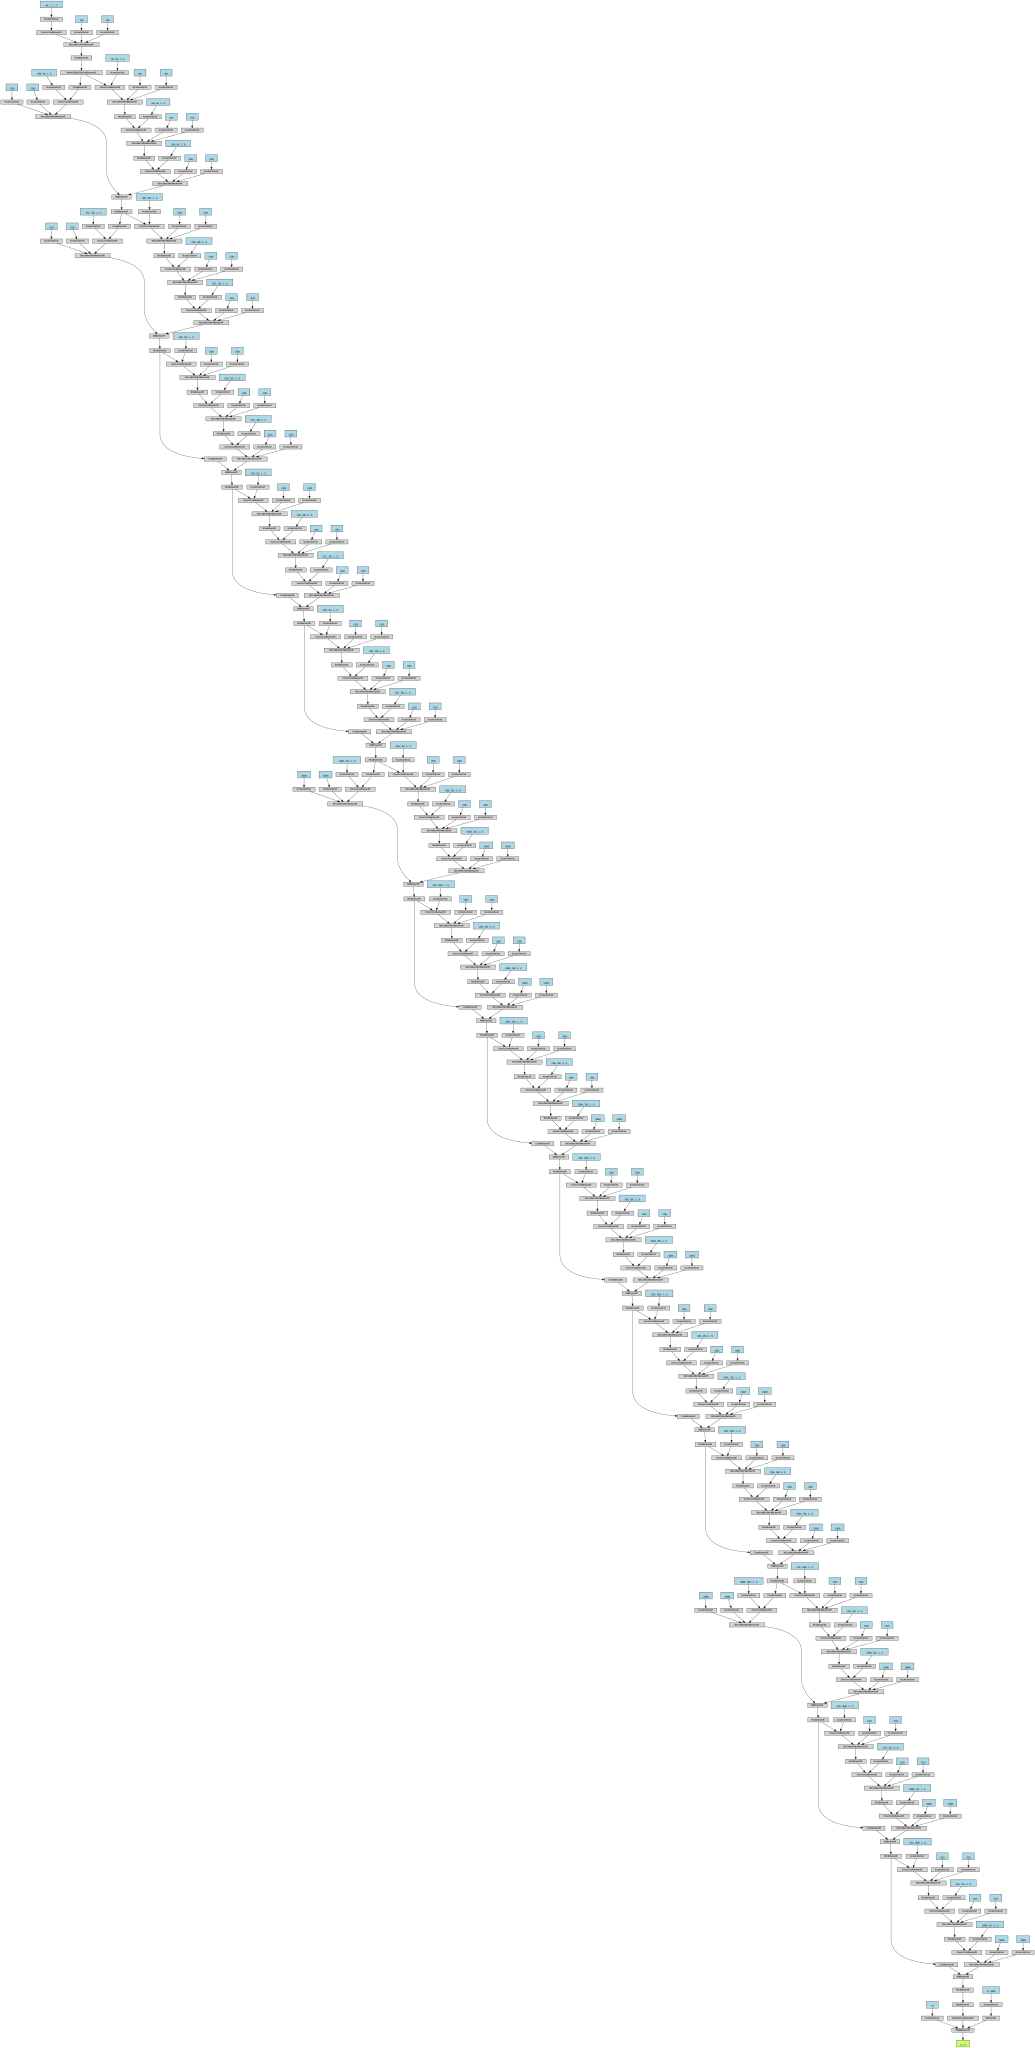

In [24]:
from torchviz import make_dot

netD = ResNet50()
out = netD(torch.zeros(1, 1, 171, 10))
make_dot(out)

In [25]:
class EarlyStopping:
    def __init__(self, mode, path, patience=3, delta=0):
        if mode not in {'min', 'max'}:
            raise ValueError("Argument mode must be one of 'min' or 'max'.")
        if patience <= 0:
            raise ValueError("Argument patience must be a postive integer.")
        if delta < 0:
            raise ValueError("Argument delta must not be a negative number.")
            
        self.mode = mode
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = np.inf if mode == 'min' else -np.inf
        self.counter = 0
        
    def _is_improvement(self, val_score):
        """Return True iff val_score is better than self.best_score."""
        if self.mode == 'max' and val_score > self.best_score + self.delta:
            return True
        elif self.mode == 'min' and val_score < self.best_score - self.delta:
            return True
        return False
        
    def __call__(self, val_score, model):
        """Return True iff self.counter >= self.patience.
        """
        
        if self._is_improvement(val_score):
            self.best_score = val_score
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            print('Val loss improved. Saved model.')
            return False
        else:
            self.counter += 1
            print(f'Early stopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                print(f'Stopped early. Best val loss: {self.best_score:.4f}')
                return True

In [26]:
def train_one_epoch(model, train_loader, optimizer, device, criterion):
    """Train model for one epoch and return the mean train_loss."""
    model.train()
    running_loss_train = 0
    for inputs, labels in train_loader:
        labels = labels.type(torch.LongTensor)
        inputs = inputs.type(torch.cuda.FloatTensor)
        #labels = labels.type(torch.cuda.FloatTensor)
        inputs, labels = inputs.to(device=device), labels.to(device=device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()
    train_loss = running_loss_train / len(train_loader.dataset)
    return train_loss

In [27]:
def validate(model, valid_loader, device, criterion):
    """Validate model and return the accuracy and mean loss."""
    model.eval()
    correct = 0
    running_loss_val = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            labels = labels.type(torch.LongTensor)
            inputs = inputs.type(torch.cuda.FloatTensor)
            #labels = labels.type(torch.cuda.FloatTensor)
            inputs, labels = inputs.to(device=device), labels.to(device=device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            pred = outputs.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
            running_loss_val += loss.item()
    val_acc = correct / len(valid_loader.dataset)
    val_loss = running_loss_val / len(valid_loader.dataset)
    return val_acc, val_loss

In [28]:
def fit(model, train_loader, valid_loader, learning_rate, num_epochs):
    criterion = nn.CrossEntropyLoss(reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    es = EarlyStopping(mode='min', path='./ResNet_Sonata.pth', patience=10)
    model = model.to(device)
    scheduler = ExponentialLR(optimizer, gamma=0.1)

    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, device, criterion)
        val_acc, val_loss = validate(model, valid_loader, device, criterion)
        scheduler.step()
        print(f'Epoch {epoch:2}/{num_epochs}',
              f'train loss: {train_loss:.4f}',
              f'val loss: {val_loss:.4f}',
              f'val acc: {val_acc:.2%}',
              sep=' | '
             )
        if es(val_loss, model):
            break

In [ ]:
model = ResNet50().to(device)
start = time.time()
fit(model, Sonata_loader, Val_loader, learning_rate=0.0001, num_epochs=150)
print(f'Total training time: {time.time() - start}')
model.load_state_dict(torch.load('ResNet_Sonata.pth'))

Epoch  1/150 | train loss: 0.7575 | val loss: 0.9711 | val acc: 25.68%
Val loss improved. Saved model.
Epoch  2/150 | train loss: 0.5340 | val loss: 1.5986 | val acc: 25.68%
Early stopping counter: 1/10
Epoch  3/150 | train loss: 0.4342 | val loss: 0.4379 | val acc: 72.30%
Val loss improved. Saved model.
Epoch  4/150 | train loss: 0.4153 | val loss: 0.3253 | val acc: 85.14%
Val loss improved. Saved model.
Epoch  5/150 | train loss: 0.4137 | val loss: 0.3151 | val acc: 85.14%
Val loss improved. Saved model.
Epoch  6/150 | train loss: 0.4136 | val loss: 0.3139 | val acc: 85.14%
Val loss improved. Saved model.
Epoch  7/150 | train loss: 0.4136 | val loss: 0.3137 | val acc: 85.14%
Val loss improved. Saved model.
Epoch  8/150 | train loss: 0.4136 | val loss: 0.3137 | val acc: 85.14%
Val loss improved. Saved model.
Epoch  9/150 | train loss: 0.4136 | val loss: 0.3137 | val acc: 85.14%
Val loss improved. Saved model.
Epoch 10/150 | train loss: 0.4136 | val loss: 0.3137 | val acc: 85.14%
Val l

In [ ]:
mode_path = "C:/Users/rezan/Arupreza/Universal Wavelet/Models/"

In [ ]:
model = ResNet50()
model.load_state_dict(torch.load(mode_path+"ResNet_Sonata.pth"))
model.eval()

In [ ]:
def get_prediction(model, dataloader):
    with torch.no_grad():
        model = model.to(device)
        model.eval()
        prediction = np.zeros(len(dataloader.dataset))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if device:
                images = images.type(torch.cuda.FloatTensor)
            prediction[k:k+len(images)] = np.argmax(model(images).data.cpu().numpy(), axis=1)
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return prediction, labels

In [ ]:
pred = get_prediction(model, Kia_loader)
y_pred = pred[0]
y_test = pred[1]

In [ ]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

In [ ]:
from sklearn.metrics import classification_report
class_names = ["Normal", "Attack"]
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
#group_names = ['True Neg','False Pos','False Neg','True Pos','True Pos','True Pos','True Pos','True Pos','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.set(rc={'figure.figsize':(15,13)})
sns.set(font_scale=1.8) #edited as suggested
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)


ax.set_xlabel('\nPredicted Category ', fontname="Times New Roman", size=22,fontweight="bold")
ax.set_ylabel('Actual Category \n', fontname="Times New Roman", size=22,fontweight="bold");
#ax.text(0.2, 2.30, 'Fig. 9. (c) Confusion Matrix CNN Multiclass Classification',fontsize=25,fontweight="bold")

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Normal", "Attack"],fontweight="bold", fontname="Times New Roman", size=18)
ax.yaxis.set_ticklabels(["Normal", "Attack"],fontweight="bold", fontname="Times New Roman", size=18)
ax.xaxis.label.set_color('darkblue')
ax.yaxis.label.set_color('darkblue')
## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

In [ ]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale=1.3) #edited as suggested

plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'BIN_CNN AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1])

plt.xlabel('False Positive Rate(TPR)', fontname="Times New Roman", size=18, fontweight="bold", color='darkblue')
plt.ylabel('True Positive Rate (FPR)', fontname="Times New Roman", size=18, fontweight="bold", color='darkblue')
#plt.text(0.02, -0.22, 'Fig. 10. (c) RUC Score CNN Binary Class Classification Vehicle 4', fontname="Times New Roman",fontsize=25,fontweight="bold")
plt.legend(loc="lower right")